# Initialization

In [1]:
import pandas as pd
import numpy as np
import json
import os
from os.path import join as pjoin
from tqdm.auto import tqdm
from pprint import pprint
from sklearn.model_selection import ParameterGrid

import scipy.stats
import torch

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter, PercentFormatter, FuncFormatter, ScalarFormatter
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.size'] = 15
import seaborn as sns

import logging
logging.basicConfig(format='%(asctime)s (%(levelname)s): %(message)s',
                   datefmt='%Y-%m-%d %H:%M:%S')
logger=logging.getLogger('main logger')
logger.setLevel(logging.INFO)

import wandb
api = wandb.Api()

In [2]:
print("matplotlib version:", matplotlib.__version__)
print("wandb version:", wandb.__version__)

matplotlib version: 3.5.1
wandb version: 0.12.14


In [3]:
# %matplotlib notebook

In [4]:
user = 'ozziko'
project = 'MLLS VisProd'

# Analyzing multiple runs and sweeps

## Downloading

In [5]:
runs = []

### Runs

In [6]:
run_paths = []
# run_ids = ['2e5ginyh', '35cdvm28']
# run_paths = ['%s/%s/%s'%(user, project, run_id) for run_id in run_ids]
# run_paths = ['ozziko/DLS_4/7i4eh931', 'ozziko/DLS_4/a58owmkf', 'ozziko/DLS_4/2f3hswja']
# -----------------------------------------------------------------------------------------
runs.extend([api.run(run) for run in run_paths])

### Sweeps

In [7]:
# sweep_ids = ['rgvkiytn', 'ggar8ann']
# sweep_name = 'cifar100 res18_v3 PEN train=val=0.1 feature noise'
sweep_name = ''
sweep_ids = []
# -----------------------------------------------------------------------------------------

if len(sweep_ids)==0 and len(run_paths)==0:
    sweep_id_ui = input("sweep_ids and run_paths are empty, enter sweep id to download or leave empty to load: ")
    if len(sweep_id_ui)>0:
        sweep_ids = [sweep_id_ui]
    # else:
    #     raise RuntimeError("sweep_ids and run_paths are empty, no sweep id entered manually -> aborting")
    # elif len(run_paths)==0:
    #     raise RuntimeError("sweep_ids=[], no sweep id entered, run_paths=[] -> aborting")

if len(sweep_ids)>0:
    sweep_paths = ['%s/%s/%s'%(user, project, sweep_id) for sweep_id in sweep_ids]
    # for sweep_path in sweep_paths:
    #     sweep = api.sweep(sweep_path)
    #     runs.extend([run for run in sweep.runs])

    for sweep_id in sweep_ids:
        logger.info(f"downloading from wandb api all runs of sweep '{sweep_id}'")
        runs.extend(api.runs(path=f"{user}/{project}", filters={"sweep": sweep_id}))
    logger.info("completed downloading runs")

2022-04-30 11:49:42 (INFO): downloading from wandb api all runs of sweep 'zm7d0x1l'
2022-04-30 11:49:44 (INFO): completed downloading runs


## Naming analysis, creating dir


In [8]:
auto_name_if_possible = True
# auto_name_if_possible = False
# -----------------------------------------------

if 'sweep_ids' in globals() and len(sweep_ids)==1:
    sweep = api.sweep(sweep_paths[0])
    sweep_name = sweep.config['name']
    sweep_id = sweep.id
    if auto_name_if_possible:
        analysis_name = f'{sweep_id} - {sweep_name}'
    else:
        msg = f"analysis name (hit enter to use sweep id + name: '{sweep_id} - {sweep_name}'): "
        analysis_name = input(msg)
        if analysis_name == '':
            analysis_name = f'{sweep_id} - {sweep_name}'
else:
    if auto_name_if_possible and len(sweep_ids)>0:
        analysis_name = f"{'+'.join(sweep_ids)} - "
        if sweep_name=='':
            analysis_name += input(f"analysis name: {analysis_name}")
        else:
            analysis_name += sweep_name
    else:
        analysis_name = input("analysis name: ")
    
analysis_path = pjoin('analysis', analysis_name)
try:
    os.makedirs(analysis_path)
    logger.info(f"created '{analysis_path}'")
except FileExistsError:
    if input(
        f"'{analysis_path}' already exists, continue and possibly overwrite results? [y]/n ")=='n':
        raise RuntimeError("aborted by user")

## Parsing/loading

### Run data & meta

In [9]:
if len(runs)>0:
    logger.info("parsing runs data & meta")
    runs_args_dict = {}
    runs_meta_dict = {}
    for run in runs:
        run_config = json.loads(run.json_config)
        run_args_dict = {arg: run_config[arg]['value'] for arg in run_config}
        run_args_dict_flat = pd.json_normalize(run_args_dict).iloc[0].to_dict()
        # keeping parsed args - no need for sweep (yaml) args that start with 'args.':
        run_args_dict_flat = {key:val for key,val in run_args_dict_flat.items() if not 'args.' in key}
        runs_args_dict[run.id] = run_args_dict_flat

        runs_meta_dict[run.id] = {
            'name': run.name,
            'state': run.state,
            'duration (s)': (pd.to_datetime(run.heartbeat_At) - pd.to_datetime(run.created_At)).total_seconds()
        }

        if hasattr(run, 'sweep') and run.sweep is not None:
            runs_meta_dict[run.id]['sweep_id'] = run.sweep.id
            runs_meta_dict[run.id]['sweep name'] = run.sweep.config['name']

    runs_args_df = pd.DataFrame.from_dict(runs_args_dict)
    runs_args_df.index.name = 'arg'
    # runs_args_df.to_excel(pjoin(analysis_path, 'runs_args_df.xlsx'))
    runs_args_df.to_pickle(pjoin(analysis_path, 'runs_args_df.pickle'))
    # torch.save(runs_args_df, pjoin(analysis_path, 'runs_args_df.pickle'))
    logger.info("saved runs_args_df")

    runs_meta_df = pd.DataFrame.from_dict(runs_meta_dict, orient='index')
    runs_meta_df.index.name = 'run id'
    runs_meta_df.to_excel(pjoin(analysis_path, 'runs_meta_df.xlsx'))
    runs_meta_df.to_pickle(pjoin(analysis_path, 'runs_meta_df.pickle'))
    logger.info("saved runs_meta_df")
else:
    logger.info("len(runs)==0 -> loading runs data & meta")
    runs_args_df = pd.read_pickle(pjoin(analysis_path, 'runs_args_df.pickle'))
    runs_meta_df = pd.read_pickle(pjoin(analysis_path, 'runs_meta_df.pickle'))
    logger.info("loaded runs_args_df and runs_meta_df")

logger.info("total - runs: %d, compute duration: %.1f hr, mean: %.1f min"%(
    len(runs_meta_df), runs_meta_df['duration (s)'].sum()/3600, runs_meta_df['duration (s)'].mean()/60))

2022-04-30 11:49:52 (INFO): parsing runs data & meta
2022-04-30 11:49:52 (INFO): saved runs_args_df
2022-04-30 11:49:53 (INFO): saved runs_meta_df
2022-04-30 11:49:53 (INFO): total - runs: 47, compute duration: 3.2 hr, mean: 4.1 min


In [10]:
# qshow(runs_meta_df)

### Run metrics

In [11]:
add_names = True
# ------------------------------

if len(runs)>0:
    logger.info("parsing run metrics")
    runs_metrics_dict = {run.id:run.summary._json_dict for run in runs}
    runs_metrics_df = pd.DataFrame.from_dict(runs_metrics_dict)
    runs_metrics_df.index.name = 'metric'
    if add_names:
        runs_metrics_df.loc['RUN NAME (not from summary)'] = [run.name for run in runs]

    runs_metrics_df['n_uniques str'] = runs_metrics_df.astype(str).nunique(axis=1)
    # n_cols = len(runs_metrics_df.columns)
    # eq = [runs_metrics_df.iloc[:,i_col]==runs_metrics_df.iloc[:,0] for i_col in range(1,n_cols)]
    # eq = pd.concat(eq, axis=1)
    # runs_metrics_df['runs eq to 1st run'] = eq.sum(axis=1)
    # runs_metrics_df.sort_values(by='runs eq to 1st run', inplace=True)
    runs_metrics_df.sort_values(by='n_uniques str', ascending=False, inplace=True)

    runs_metrics_df.to_excel(pjoin(analysis_path, 'runs_metrics_df.xlsx'))
    runs_metrics_df.to_pickle(pjoin(analysis_path, 'runs_metrics_df.pickle'))
    logger.info("saved runs_metrics_df")
else:
    logger.info("len(runs)==0 -> loading runs_metrics_df")
    runs_metrics_df = pd.read_pickle(pjoin(analysis_path, 'runs_metrics_df.pickle'))
    logger.info("loaded runs_metrics_df")

2022-04-30 11:49:54 (INFO): parsing run metrics
2022-04-30 11:49:54 (INFO): saved runs_metrics_df


In [12]:
# to compare runs open runs_metrics_df.xlsx, NOT qshow - qgrid doens't show things written inside <>

## Dropping unfinished runs

In [13]:
run_states_series = runs_meta_df['state']
finished_runs_series = run_states_series[run_states_series == 'finished']
unfinished_runs_series = run_states_series[run_states_series != 'finished']
if len(unfinished_runs_series)>0:
    logger.warning(f"unfinished_runs_series (len: {len(unfinished_runs_series)}):")
    pprint(unfinished_runs_series)
    unfinished_ui = input("\nhow to deal with unfinished runs: drop/[abort]/continue ")
    if unfinished_ui not in ['drop', 'continue']:
        raise RuntimeError("aborted by user")

    runs_to_drop = unfinished_runs_series.index
    crashed_runs_series = run_states_series[run_states_series == 'crashed']
    if unfinished_ui=='drop' and 0 < len(crashed_runs_series) < len(unfinished_runs_series):
            drop_ui = input("drop all unfinished runs (failed+crashed), or only crashed ones? all/[crashed] ")
            if drop_ui!='all':
                runs_to_drop = crashed_runs_series.index
    runs_to_keep = run_states_series.index[~run_states_series.index.isin(runs_to_drop)]

if len(unfinished_runs_series)>0 and unfinished_ui == 'drop':
    runs_args_df = runs_args_df[runs_to_keep]

2022-04-30 11:49:54 (WARNING): unfinished_runs_series (len: 2):


run id
n2jxoal3    crashed
xruhipv0     failed
Name: state, dtype: object


## Auto-inferring swept_args

In [14]:
unique_vals['data.seed']

NameError: name 'unique_vals' is not defined

In [ ]:
non_swept_non_constant_args = 'cfg.run_name, cfg.output_dir, data.dir, ' \
    'wandb.sweep_name, wandb.run_naming_args, ' \
    'cfg.last_git_commit'.split(', ') # the only non-swept args that are expected to change between runs
ignore_NaNs = True
# ------------------------------------------------------------
logger.info("auto-inferring swept_args")

runs_args_df_ext = runs_args_df.copy()
unique_vals = {}
for arg in runs_args_df_ext.index:
    unique_vals[arg] = set(runs_args_df_ext.loc[arg].astype(str).unique())
#     if 'nan' in unique_vals[arg]:
#         logger.info(f"'{arg}' unique vals contain 'nan'")
#     if ignore_NaNs and 'nan' in unique_vals[arg]:
#         unique_vals[arg] -= {'nan'}
#         logger.info(f"'nan' was removed from '{arg}' unique vals (ignore_NaNs == True)")

nunique_vals = {arg:len(unique_vals[arg]) for arg in unique_vals}
runs_args_df_ext['n_uniques'] = pd.Series(nunique_vals)
# runs_args_df_ext['n_uniques'] = runs_args_df_ext.astype(str).nunique(axis=1)
# runs_args_df_ext['n_uniques'] = runs_args_df_ext.nunique(axis=1)
runs_args_df_ext.sort_values(by='n_uniques', ascending=False, inplace=True)

experiment_alpha_on = []
if len(runs_args_df.columns) > 2:
    swept_args = runs_args_df_ext.query("n_uniques>1").index.tolist()
    swept_args_original = swept_args.copy()
    for arg in non_swept_non_constant_args:
        if arg in swept_args:
            swept_args.remove(arg)
            logger.info(f"removed {arg} from swept_args (arg in non_swept_non_constant_args)")

    if ('cfg.seed' in swept_args) and ('data.seed' in swept_args):
        seeds_joint_dist = runs_args_df.T.groupby(['cfg.seed', 'data.seed']).size()
        if len(seeds_joint_dist) == nunique_vals['cfg.seed']:
            swept_args.remove('cfg.seed')
            logger.info(f"auto-recognized cfg.seed = -1 in sweep, so its vals are like data.seed -> removed 'cfg.seed' from swept_args")
    if 'data.seed' in swept_args:
        swept_args.remove('data.seed')
        logger.info(f"removed 'data.seed' from swept_args since it's decided by 'data.num_split'")
    
    # if auto_reduce_alphas_by_exp_alpha and 'experiment_alpha' in swept_args:
    #     if 'experiment_alpha_on' in runs_args_df.index:
    #         experiment_alpha_on = runs_args_df.loc['experiment_alpha_on'].unique().tolist()
    #         if len(experiment_alpha_on)==1:
    #             experiment_alpha_on = experiment_alpha_on[0]
    #             logger.info(f"auto_reduce_alphas_by_exp_alpha==True, experiment_alpha_on: '{experiment_alpha_on}'")
    #             if 'train' in experiment_alpha_on:
    #                 swept_args.remove('dataloading.train.Dirichlet_alpha')
    #                 logger.info("removed 'dataloading.train.Dirichlet_alpha' from swept_args")
    #             if 'val' in experiment_alpha_on:
    #                 swept_args.remove('dataloading.val.Dirichlet_alpha')
    #                 logger.info("removed 'dataloading.val.Dirichlet_alpha' from swept_args")
    #             if 'test' in experiment_alpha_on:
    #                 swept_args.remove('data.test.Dirichlet_alpha')
    #                 logger.info("removed 'data.test.Dirichlet_alpha' from swept_args")
        # else:
        #     raise RuntimeError("auto_reduce_alphas_by_exp_alpha==True, 'experiment_alpha' in swept_args but 'experiment_alpha_on' not in runs_args_df.index")
        
    print("auto inferred swept_args:")
    pprint(swept_args)

2022-04-29 19:25:21 (INFO): auto-inferring swept_args
2022-04-29 19:25:21 (INFO): removed cfg.run_name from swept_args (arg in non_swept_non_constant_args)
2022-04-29 19:25:21 (INFO): removed cfg.output_dir from swept_args (arg in non_swept_non_constant_args)
2022-04-29 19:25:21 (INFO): auto-recognized cfg.seed = -1 in sweep, so its vals are like data.seed -> removed 'cfg.seed' from swept_args
2022-04-29 19:25:21 (INFO): removed 'data.seed' from swept_args since it's decided by 'data.num_split'


auto inferred swept_args:
['VP.lr', 'data.num_split', 'VP.lambda_decoupling', 'training.batch_size']


## Verifying constant non-swept args

In [ ]:
show_run_name = True
# show_run_name = False
# -----------------------------------------------------------------------------------------

if 'swept_args' in locals():
    logger.info("verifying constant non-swept args")
    runs_args_df_ext['is_swept'] = runs_args_df_ext.index.isin(swept_args)

    # verifying constant non-swept args
    runs_args_df_inconsistent = runs_args_df_ext.query(
        f"not is_swept & n_uniques==2 & arg not in {non_swept_non_constant_args} & arg not in {swept_args_original}")
    if len(runs_args_df_inconsistent)>0:
        logger.warning("not all non-swept args are the same in all runs! check runs_args_df_inconsistent")
        pprint(runs_args_df_inconsistent)
        if input("continue? y/[n]")!='y':
            raise RuntimeError("aborted by user")

    else:
        logger.info("all non-swept args are the same in all runs :-)")

runs_args_df_ext.to_excel(pjoin(analysis_path, 'runs_args_df_ext.xlsx'))
logger.info("saved runs_args_df_ext")

2022-04-29 19:25:23 (INFO): verifying constant non-swept args
2022-04-29 19:25:23 (INFO): all non-swept args are the same in all runs :-)
2022-04-29 19:25:24 (INFO): saved runs_args_df_ext


## Inferring search grid, verifying there are no holes

In [ ]:
search_grid_dict = {} # if not supplied as arg:set(vals) - inferred from swept_args in runs
ignore_NaNs = True
# ----------------------------------------------------------
if len(search_grid_dict)==0:
    search_grid_dict = {arg:set(runs_args_df.loc[arg].unique())-{np.nan} for arg in swept_args}
    print("Search grid:")
    pprint(search_grid_dict)
#     swept_args_nuniques_prod = runs_args_df_ext.query("is_swept")['n_uniques'].prod()
# else:
swept_args_nuniques_prod = np.prod([len(vals_set) for vals_set in search_grid_dict.values()])

if 'cfg.inference' in search_grid_dict and str(search_grid_dict['cfg.inference'])=="{nan, ''}":
    logger.info("search_grid_dict['cfg.inference']=={'', np.nan} -> skipped (some runs ran "
                "before cfg.inference was added to params)")
    del search_grid_dict['cfg.inference']
    swept_args.remove('cfg.inference')
    swept_args_nuniques_prod /= 2

if 'cfg.seed' in search_grid_dict:
    cfg_seeds_sorted = sorted(search_grid_dict['cfg.seed'])
if 'data.seed' in search_grid_dict:
    data_seeds_sorted = sorted(search_grid_dict['data.seed'])
    if np.array_equal(np.array(cfg_seeds_sorted)+5000, np.array(data_seeds_sorted)):
        if input(f"data seeds = cfg seeds +5000, was args.data.seed=-1 so data seeds are to be ignored "
              "in verifying no holes in search grid (since each data seed = cfg seed + 5000)? [y]/n")!='n':
            swept_args_nuniques_prod /= len(data_seeds_sorted)

if swept_args_nuniques_prod == len(runs_meta_df):
    logger.info(f"search grid has no holes: swept args unique values product ({swept_args_nuniques_prod}) == len(runs_meta_df) ({len(runs_meta_df)})")
else:
    warning = f"search grid has holes: swept args unique values product ({swept_args_nuniques_prod}) != len(runs_meta_df) ({len(runs_meta_df)})"
    if input(f"{warning} -> continue? y/[n]")!='y':
        raise RuntimeError("aborted by user")

2022-04-29 19:25:25 (INFO): search grid has no holes: swept args unique values product (54) == len(runs_meta_df) (54)


Search grid:
{'VP.lambda_decoupling': {1000000, 10000, 100000},
 'VP.lr': {0.0001, 0.01, 0.001},
 'data.num_split': {5000, 5001, 5002},
 'training.batch_size': {1024, 256}}


In [ ]:
print(search_grid_dict)

{'VP.lr': {0.0001, 0.01, 0.001}, 'data.num_split': {5000, 5001, 5002}, 'VP.lambda_decoupling': {1000000, 10000, 100000}, 'training.batch_size': {1024, 256}}


## Analyzing over-fitting

### Analyzing

In [ ]:
analyze_overfitting = False
# analyze_overfitting = True
# ----------------------------

if analyze_overfitting:
    histories = {'accuracy - micro <val>':[],
                 'accuracy - micro <train-val diff>':[]}
    for run in tqdm(runs):
        for metric in histories:
            run_hist_df = run.history()
            series = run_hist_df[metric].dropna()
            series.index = range(len(series))
            series.name = run.id
            histories[metric].append(series)
    for metric in histories:
        histories[metric] = pd.concat(histories[metric], axis=1)

    runs_swept_args_df = runs_args_df_ext.query("is_swept").T
    runs_swept_args_df.drop(index=['is_swept', 'n_uniques'], inplace=True)
    runs_swept_args_df.sort_values(by=list(runs_swept_args_df.columns), ascending=True, inplace=True)
    display(runs_swept_args_df)

### Plotting

In [ ]:
fig_size = (4,4)
line_opacity = 0.7
line_width = 1.1
x_label = 'accuracy - micro <train-val diff>'
y_label = 'accuracy - micro <val>'

format_as_percents = True

args_to_keep = {}
# args_to_keep['training.wd'] = [0, 1]

legend_font_size = 10
legend_loc='upper left'
legend_anchor_bbox=(0.5, -0.85)
# ylim = [0.3, 0.45]
# xlim = [0, 0.2]
ylim = []
xlim = []
# -----------------------------------
if analyze_overfitting:
    for arg in args_to_keep:
        if arg not in runs_swept_args_df.columns:
            raise RuntimeError(f"'{arg}' is in args_to_keep but not in swept args, remove from args_to_keep")
    fig = plt.figure(figsize = fig_size)

    for run_id in runs_swept_args_df.index:
        skip = False
        for arg in args_to_keep:
            val = runs_swept_args_df.loc[run_id, arg]
            if val not in args_to_keep[arg]:
                skip = True
        if skip:
            continue
        label = ', '.join(runs_swept_args_df.loc[run_id].astype(str).tolist())
        x = histories[x_label][run_id].dropna()
        y = histories[y_label][run_id].dropna()
        if len(x)<len(y):
            y = y[x.index]
        else:
            x = x[y.index]
        plt.plot(x, y, '-', label=label, alpha=line_opacity, linewidth=line_width)
    fig.patch.set_facecolor('white')
    legend_title = ', '.join(runs_swept_args_df.columns.tolist())
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.legend(title=legend_title,
               fontsize=legend_font_size, title_fontsize=legend_font_size,
               loc=legend_loc, bbox_to_anchor=legend_anchor_bbox,
              )
    if format_as_percents:
        ax = plt.gca()
        ax.yaxis.set_major_formatter(PercentFormatter(1.))
        ax.xaxis.set_major_formatter(PercentFormatter(1.))

    if len(xlim)>0:
        plt.xlim(xlim)
    if len(ylim)>0:
        plt.ylim(ylim)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    plt.show()
    
    print("Analysis:", os.path.split(analysis_path)[-1])
    print("Search grid:")
    pprint(search_grid_dict)

## Analyzing selected run metrics

In [16]:
runs_metrics_df.index

Index(['RUN NAME (not from summary)', 'seen/VisProd: train ',
       'seen/VisProd+unseen-EM: val ', 'seen/VisProd+EM: val ',
       'harmonic/VisProd: val ', 'train-val time (s)',
       'harmonic/VisProd: test ', 'harmonic/VisProd+EM: val ',
       'HSIC loss per sample/train', 'harmonic/VisProd+EM: test ',
       'unseen acc/val', 'total acc/VisProd: train ',
       'MI g.t. loss per sample/train', 'seen/VisProd: test ',
       'unseen/VisProd+EM: val ', 'total acc/VisProd+unseen-EM: val ',
       'seen/VisProd: val ', 'total acc/VisProd+EM: val ',
       'seen/adapted VisProd: test ', 'seen acc/train',
       'total acc/adapted VisProd: test ', 'total loss per sample/train',
       'harmonic/VisProd+unseen-EM: test ', 'joint acc/val',
       'HSIC loss per sample/val', 'total loss per sample/val',
       'shape loss per sample/train', 'color loss per sample/val',
       'shape acc/train', 'joint acc/train',
       'total acc/VisProd+unseen-EM: test ', 'total acc/VisProd: val ',
   

In [ ]:
selected_metrics = """
accuracy - micro <best train>, accuracy - micro <best val>, accuracy - micro <test>,
accuracy - macro <best train>, accuracy - macro <best val>, accuracy - macro <test>,
epoch prior loss <best train>, epoch prior loss <best val>, epoch prior loss <test>,
calibration MAE <best train>, calibration MAE <best val>, calibration MAE <test>,
best epoch, last epoch, net trainable params
"""
# selected_metrics = """
# accuracy - micro <train>, accuracy - micro <val>, accuracy - micro <test>,
# accuracy - macro <val>, accuracy - macro <test>,
# mean prior RMSE <train>, mean prior RMSE <val>,
# mean prior RMSE <test>, mean prior MAE <val>, mean prior MAE <test>, last epoch
# """
# ----------------------------------------------------------------
logger.info("analyzing selected metrics")

runs_metrics_df_T = runs_metrics_df.T
runs_metrics_df_T.drop(index='n_uniques str', inplace=True)
selected_metrics = [splt.strip() for splt in selected_metrics.replace('\n','').split(',')]

runs_selected_metrics_df = runs_metrics_df_T[selected_metrics]

# runs_selected_metrics_df.to_excel(pjoin(analysis_path, 'runs_selected_metrics_df.xlsx'))
# logger.info("saved runs_selected_metrics_df")

runs_swept_args_df = runs_args_df_ext.query("is_swept").T
runs_swept_args_and_selected_metrics_df = runs_swept_args_df.merge(runs_selected_metrics_df, left_index=True, right_index=True)
runs_swept_args_and_selected_metrics_df.to_excel(pjoin(analysis_path, 'runs_swept_args_and_selected_metrics_df.xlsx'))
logger.info("saved runs_swept_args_and_selected_metrics_df")
#
# runs_summary_swept_args_and_selected_metrics_df = runs_summary_df.merge(runs_swept_args_and_selected_metrics_df, left_index=True, right_index=True)
# runs_summary_swept_args_and_selected_metrics_df.to_excel(pjoin(analysis_path, 'runs_summary_swept_args_and_selected_metrics_df.xlsx'))
# logger.info("saved runs_summary_swept_args_and_selected_metrics_df")

n_loaded_tests: [10] 


2021-12-20 15:31:29 (INFO): analyzing selected metrics
2021-12-20 15:31:30 (INFO): saved runs_swept_args_and_selected_metrics_df


In [ ]:
# runs_selected_metrics_df_non_test

In [ ]:
# runs_metrics_df_T.loc['8vrw5kt1', 'accuracy - micro <val>']

In [ ]:
# runs_selected_metrics_df_non_test.loc['8vrw5kt1']

## Reading baseline results

In [ ]:
# baseline_df_path = pjoin('analysis', 'cifar10_test_size=8000_with_acc.xlsx')
# baseline_df = pd.read_excel(baseline_df_path, index_col=0, header=[0,1,2])
# baseline_df = pd.read_excel(baseline_df_path, index_col=0)
# baseline_df

In [ ]:
# dataset = 'cifar10'
# baseline = 'em:BCTS'
# metric = 'adapted_acc_micro'

# query = f"dataset=='{dataset}' & model=='{baseline}'"
# bs_model_df = baseline_df.query(query).copy()

# for metric in ['adapted_acc_micro', 'delta_acc']:
#     bs_model_df[metric] = bs_model_df[metric].apply(lambda x: x[1:-1].split())\
#         .apply(lambda x: np.array([float(val) for val in x]))
#     bs_model_df[metric+' mean'] = bs_model_df[metric].apply(np.mean)
# bs_model_df['unadapted acc mean'] = bs_model_df['adapted_acc_micro mean'] - bs_model_df['delta_acc mean']
# bs_model_df

## Analysis defitions

### Aggregating seeds & optimizing hyper-tuning

In [ ]:
# qshow(runs_swept_args_and_selected_metrics_df)

Finding optimal runs:

Optimizing metric_to_optimize by searching over the optiaml swept_args that are not in args_to_fix, keeping args_to_fix fixed in the search, such that each set of values in the outer product of args_to_fix gets a row in the final opt_df, of the (optimal) hyper-parameters that gave the optimal metric_to_optimize

In [ ]:
# aggs_to_use = ['median', 'mean', 'sem']
aggs_to_use = ['mean', 'sem']
# aggs_to_use = ['mean', 'std']
# aggs_to_use = ['mean', 'std', 'sem']
# aggs_to_use = ['mean']

ddof = 1
show_ddof = False
# show_ddof = True

# short_arg_names = True # taking the last part in name, split by dots, e.g. 'training.lr' - > 'lr'
short_arg_names = False
# ---------------------------------------------------------------------
def agg():
    assert direction in [-1, 1]

    non_reduced_args = list(set(swept_args) - {'data.seed', 'cfg.seed'})
    if len(non_reduced_args)==0:
        logger.info("no swept args except 'data.seed', 'cfg.seed'")
        base_cfg_seeds = [0, 10, 20]
        base_data_seeds = [5000, 5001, 5002]
        base_runs = runs_swept_args_and_selected_metrics_df.query(
            f"`cfg.seed` in {base_cfg_seeds} & `data.seed` in {base_data_seeds}")

        logger.info("'accuracy - micro <test delta>' mean ± std for BASE runs (seeds = %s x %s): %.6f%% ± %.6f%%" % (
            base_cfg_seeds, base_data_seeds,
            100 * base_runs['accuracy - micro <test delta>'].mean(),
            100 * base_runs['accuracy - micro <test delta>'].sem(ddof=1),
        ))
        logger.info("'accuracy - micro <test delta>' mean ± std for ALL runs: %.6f%% ± %.6f%%" % (
            100 * runs_swept_args_and_selected_metrics_df['accuracy - micro <test delta>'].mean(),
            100 * runs_swept_args_and_selected_metrics_df['accuracy - micro <test delta>'].sem(ddof=1),
        ))
    else:
        logger.info("aggregating seeds")
        df = runs_swept_args_and_selected_metrics_df.copy()

        agg_size = df.groupby(non_reduced_args, as_index=True).size()

        selected_metrics_split = []
        selected_metrics_no_phases = []
        for full_metric in selected_metrics:
            if '<' in full_metric:
                metric = full_metric[:full_metric.find(' <')]
                phase = full_metric[full_metric.find(' <')+2:-1]
            else:
                metric = full_metric
                phase = ''
            selected_metrics_split.append((metric, phase))
            selected_metrics_no_phases.append(metric)

        # good only if no NaNs in metric columns:
        # agg_mean = df.groupby(non_reduced_args, as_index=True).mean()
        # agg_mean.columns = pd.MultiIndex.from_tuples([[col, 'mean'] for col in selected_metrics])
        # agg_sem = df.groupby(non_reduced_args, as_index=True).sem(ddof=0)
        # agg_sem.columns = pd.MultiIndex.from_tuples([[col, 'sem'] for col in selected_metrics])
        # agg_median = df.groupby(non_reduced_args, as_index=True).median()
        # agg_median.columns = pd.MultiIndex.from_tuples([[col, 'median'] for col in selected_metrics])

        # dropping NaNs per metric column, with all swept_args columns:
        dfs_partial_no_na = []
        for metric in selected_metrics:
            df_ = df[swept_args+[metric]].dropna(how='any')
            df_[metric] = df_[metric].astype(float)
            dfs_partial_no_na.append(df_)

        agg_dfs = []
        for agg in aggs_to_use:
            if agg=='mean':
                agg_means = [df_.groupby(non_reduced_args, as_index=True).mean() for df_ in dfs_partial_no_na]
                agg_mean = pd.concat(agg_means, axis=1, join='outer')
                agg_mean.columns = pd.MultiIndex.from_tuples(
                                                [[metric, phase, 'mean'] for metric, phase in selected_metrics_split])
                agg_dfs.append(agg_mean)

            elif agg=='std':
                agg_stds = [df_.groupby(non_reduced_args, as_index=True).std(ddof=ddof) for df_ in dfs_partial_no_na]
                agg_std = pd.concat(agg_stds, axis=1, join='outer')
                if show_ddof:
                    std_col = f'std(ddof={ddof})'
                else:
                    std_col = 'std'
                agg_std.columns = pd.MultiIndex.from_tuples(
                                                [[metric, phase, std_col] for metric, phase in selected_metrics_split])
                agg_dfs.append(agg_std)

            elif agg=='sem':
                agg_sems = [df_.groupby(non_reduced_args, as_index=True).sem(ddof=ddof) for df_ in dfs_partial_no_na]
                agg_sem = pd.concat(agg_sems, axis=1, join='outer')
                if show_ddof:
                    sem_col = f'sem(ddof={ddof})'
                else:
                    sem_col = 'sem'
                agg_sem.columns = pd.MultiIndex.from_tuples(
                                                [[metric, phase, sem_col] for metric, phase in selected_metrics_split])
                agg_dfs.append(agg_sem)

            elif agg == 'median':
                agg_medians = [df_.groupby(non_reduced_args, as_index=True).median() for df_ in dfs_partial_no_na]
                agg_median = pd.concat(agg_medians, axis=1, join='outer')
                agg_median.columns = pd.MultiIndex.from_tuples(
                                                [[metric, phase, 'median'] for metric, phase in selected_metrics_split])
                agg_dfs.append(agg_median)

        # grouping levels
        agg_df = pd.concat(agg_dfs, axis=1, join='outer')
        seeds_col = 'seeds (cfg & data)'
        agg_df[('', '', seeds_col)] = agg_size
        agg_df = agg_df.reindex(columns=set(agg_df.columns.get_level_values(level=0)), level=0)  # group level 0
        agg_df = agg_df.reindex(columns=set(agg_df.columns.get_level_values(level=1)), level=1)  # group level 1

        # re-ordering columns
        non_reduced_arg_cols = []
        non_reduced_arg_cols_renamed = []
        agg_df.reset_index(inplace=True)
        for arg in args_to_fix:
            non_reduced_arg_cols.append((arg, '', ''))
            non_reduced_arg_cols_renamed.append(('', '', arg))

        args_to_opt = list(set(non_reduced_args) - set(args_to_fix))
        for arg in args_to_opt:
            non_reduced_arg_cols.append((arg, '', ''))
            non_reduced_arg_cols_renamed.append(('', '', arg))

        metric_cols = []
        for metric, phase in selected_metrics_split:
            for agg in aggs_to_use:
                if show_ddof:
                    if agg == 'sem':
                        agg_ = sem_col
                    if agg == 'std':
                        agg_ = std_col
                else:
                    agg_ = agg
                metric_cols.append((metric, phase, agg_))

        ordered_cols = non_reduced_arg_cols + [('', '', seeds_col)] + metric_cols

        # cols_no_size = agg_df.columns.to_list()
        # cols_no_size.remove(('seeds (model+data)', '', ''))
        # agg_df = agg_df[[('seeds (model+data)', '', '')]+cols_no_size] # re-ordering
        # first_cols = ['seeds (model+data)', 'accuracy - micro', 'mean prior RMSE', 'mean prior MAE']
        # cols_no_first = agg_df.columns.to_list()
        # cols_no_first.remove(first_cols)
        agg_df = agg_df[ordered_cols]
        # renaming arg cols from (arg, '', '') to ('', '', arg)
        if short_arg_names:
            non_reduced_arg_cols_renamed = [('','', arg.split('.')[-1].strip()) for _,_,arg in non_reduced_arg_cols_renamed]
        agg_df.columns = pd.MultiIndex.from_tuples(
            non_reduced_arg_cols_renamed + [('', '', seeds_col)] + metric_cols)

        agg_df.to_excel(pjoin(analysis_path, 'agg_df.xlsx'))
        logger.info("saved agg_df")

        # optimizing -------------------------------------------
        logger.info("optimizing")
        opt_df_indices = []

        args_to_fix_vals = {arg: search_grid_dict[arg] for arg in args_to_fix}
        args_to_fix_vals_grid = ParameterGrid(args_to_fix_vals)

        for args_to_fix_vals_dict in args_to_fix_vals_grid:
            filtered_df = agg_df.copy()
            for arg, val in args_to_fix_vals_dict.items():
                arg_ = arg
                if short_arg_names:
                    arg_ = arg.split('.')[-1].strip()
                filtered_df = filtered_df[filtered_df[('', '', arg_)] == val]
            opt_row = direction * filtered_df[metric_to_optimize].argmax()
            opt_idx = filtered_df.index[opt_row]
            opt_df_indices.append(opt_idx)

        opt_df = agg_df.iloc[opt_df_indices].copy()

        for arg in args_to_opt:
            arg_ = arg
            if short_arg_names:
                arg_ = arg.split('.')[-1].strip()
            opt_df.rename(columns={arg_: f'OPT {arg_}'}, level=2, inplace=True)
        args_to_fix_short = [arg.split('.')[-1].strip() for arg in args_to_fix]
        args_to_fix_short_str = ', '.join(args_to_fix_short)
        opt_df.to_excel(pjoin(analysis_path, f'opt_df by {metric_to_optimize} grouped by {args_to_fix_short_str}.xlsx'))
        logger.info("saved opt_df")
        return agg_df, opt_df, std_col, sem_col

### Plotting

In [75]:
# fig = plt.figure()
# x = [1,12,120,1020]
# plt.plot(x, [1,2,3,4])
# ax = plt.gca()

# plt.xscale('log')

# formatter = ScalarFormatter()
# formatter.set_scientific(False)
# ax.xaxis.set_major_formatter(formatter)

# plt.xticks(ticks=x)

# fig.patch.set_facecolor('white')

* x = args_to_fix[0]
* y = optimal 'best val' results of metric_to_plot = (metric_to_optimize[0], phase_to_plot, metric_to_optimize[2])
* hues (seaborn terminology) = all combinations of args_to_fix[1:]
* line style by arg_for_line_style

In [76]:
if 'cfg.seed' in search_grid_dict:
    n_loaded_tests_ = n_loaded_tests * len(search_grid_dict['cfg.seed'])
else:
    n_loaded_tests_ = n_loaded_tests

def plot():
    df = opt_df.copy()
    plotted_series_list = []

    if error_bands != 'none':
        if error_bands not in aggs_to_use:
            raise RuntimeError(f"got error_bands='{error_bands}' which are not in aggs_to_use='{aggs_to_use}'!")
    
    phase = metric_to_plot[1]
    if len(baselines)>0:
        if phase != 'test':
            raise RuntimeError(
                f"got baseline_compare=True but phase_to_plot='{phase}' (comparison - only on 'test')!")
    
    if baseline_tests_as_DLS and n_loaded_tests_ == 0:
        zero_n_loaded_tests_ui = input("n_loaded_tests_ == 0 but baseline_tests_as_DLS, "
                "meaning only one non-loaded test was done per DLS run and it IS " 
                "different from baseline tests - do you want to still compare with 1st "
                "baseline test, or abort? y/[abort] ")
    
    if short_arg_names:
        args_to_fix_ = args_to_fix_short
    else:
        args_to_fix_ = args_to_fix
    x_col = args_to_fix_[0]

    if len(set(vals_to_keep.keys()) - set(args_to_fix_))>0:
        raise RuntimeError("there are keys in vals_to_keep that does not appear in args_to_fix_!")

    hues_dict = {}
    if len(args_to_fix) == 1:
        hues = [None]
    else:
        for i_hue_col in range(1, len(args_to_fix_)):
            hue_col = args_to_fix_[i_hue_col]
            hues_dict[hue_col] = df[('', '', hue_col)].unique()
            if i_hue_col>0 and hue_col in vals_to_keep:
                non_existing_vals_to_keep = set(vals_to_keep[hue_col]) - set(hues_dict[hue_col])
                if len(non_existing_vals_to_keep)>0:
                    raise RuntimeError(f"remove {non_existing_vals_to_keep} from vals_to_keep['{hue_col}'] to avoid confusion, they don't appear in opt_df!")
                hues_dict[hue_col] = set(hues_dict[hue_col]) & set(vals_to_keep[hue_col])
            hues_dict[hue_col] = list(hues_dict[hue_col])
            hues_dict[hue_col].sort()
        hues =  ParameterGrid(hues_dict)
        # since ParameterGrid is ordered by keys abc and not by key order:
        hues_df = pd.DataFrame(hues).sort_values(by=args_to_fix_[1:])[args_to_fix_[1:]]

    line_style = '-o' # in case there are no other
    if arg_for_line_style in hues_dict:
        hue_vals = hues_dict[arg_for_line_style]
        line_styles = {hue_val: '-.o' for hue_val in hue_vals}
        line_styles[hue_vals[0]] = '-o'
        if len(hue_vals)>1: line_styles[hue_vals[1]] = '--o'


    fig = plt.figure(figsize=fig_size)

    for i_hue in range(len(hues)):
        if len(args_to_fix) == 1:
            hue_df = df.copy()
            if 'model.variant' in swept_args:
                label = 'DLS'
            else: # architecture is the same for all runs
                architecture = runs_args_df.loc['model.architecture'].iloc[0]
                label = architecture
        else:
            hue = hues_df.iloc[i_hue].to_dict()
            hue_df = df.copy()
            line_style = '-o'
            for hue_col, hue_val in hue.items():
                hue_df = hue_df[hue_df[('', '', hue_col)]==hue_val]
                if hue_col==arg_for_line_style and hue_col in hues_dict:
                    line_style = line_styles[hue_val]
    #         label = legend_separator.join([str(hue_val) for hue_col, hue_val in hue.items() 
    #                            if len(hues_dict[hue_col])>1 or len(baselines)>1])
            # label = prefix+legend_separator.join([str(hue_val) for hue_col, hue_val in hue.items()])
            label = []
            for hue_col, hue_val in hue.items():
                key = hue_val
                if minimal_mode:
#                     if hue_col == 'model.variant':
#                         key = hue_val.split(' ')[1].replace('->', '-')
#                         key = hue_val.replace('->', '-')
#                         key = hue_val.replace('*', '')
#                     print(f"hue_col: '{hue_col}'")
                    if hue_col == 'data.input_source':
                        if key == 'output_layer=-1 logits':
                            key = 'dim = 100'
                        elif key == 'output_layer=-2 logits':
                            key = 'dim = 512'
                        elif key == 'output_layer=-4 logits':
                            key = 'dim = 1024'
                    elif hue_col == 'data.dataset':
                        if 'synthetic 1D' in hue_val:
                            if 'train-CLIPPED' in hue_val:
                                key = 'train-clipped'
                            else:
                                key = 'no clipping'
                
                if isinstance(key, float):
#                     key = '%.1e'%key
                    key = str(key)
                else:
                    key = str(key)
                label.append(key)
            
            if prefix =='':
                label = legend_separator.join(label)
            else:
                label = f'{prefix}: '+ legend_separator.join(label)

        if sort_x:
#             if x_col=='training.train.rand_transforms':
#                 hue_df[('', '', x_col)] = hue_df[('', '', x_col)].str.replace('off', '0')
#                 hue_df[('', '', x_col)] = hue_df[('', '', x_col)].str.replace(' mean cls std, zero clip', '')
            hue_df.sort_values(('', '', x_col), ascending=True, inplace=True)

        x = hue_df[('', '', x_col)].copy()
        x_ = x.copy()
        if log10_xvals:
            x = x.astype(float)
            x[x!=0] = np.log10(x[x!=0])
#         if x_col in vals_to_keep:
#             x = x[x.isin(vals_to_keep[x_col])]

        y = hue_df[metric_to_plot]
        if one_minus_metric:
            y = 1-y
        base_line = plt.plot(x, y, line_style, label=label, alpha=line_opacity, linewidth=line_width)
        plotted_series = y.copy()
        plotted_series.index = x.copy()
        plotted_series.index.name = x_col
        if error_bands=='none':
            plotted_series.name = label
        else:
            plotted_series.name = (label, metric_to_plot[-1])
        plotted_series_list.append(plotted_series)

        if error_bands == 'std':
            err_name = std_col
        elif error_bands == 'sem':
            err_name = sem_col
        elif error_bands == 'none':
            err_name = None
        else:
            raise NotImplementedError
        if err_name is not None:
            err_col = (metric_to_plot[0], metric_to_plot[1], err_name)
            err = hue_df[err_col]
            plt.fill_between(x, y + err, y - err, facecolor=base_line[0].get_color(), alpha=err_opacity)

            if err_in_table:
                plotted_series = err.copy()
                plotted_series.index = x.copy()
                plotted_series.index.name = x_col
                plotted_series.name = (label, err_name)
                plotted_series_list.append(plotted_series)

    # plotting baseline
    if len(baselines)>0:
        if args_to_fix[0] not in ['experiment_alpha', 'data.test.Dirichlet_alpha']:
            raise RuntimeError("baseline comparison requires x = alpha, set args_to_fix to have experiment_alpha as first arg")

        baseline_df = pd.read_excel(baseline_df_path, index_col=0)

        for baseline in baselines:

            if baseline != 'unadapted':
                if metric_to_plot[0]=='accuracy - micro':
                    metric = 'adapted_acc_micro'
                elif metric_to_plot[0]=='accuracy - macro':
                    metric = 'adapted_acc_macro'
                elif metric_to_plot[0]=='epoch prior loss':
                    metric = 'KLDiv'
                elif metric_to_plot[0]=='epoch prior MAE':
                    metric = 'prior_MAE'
                elif metric_to_plot[0]=='epoch prior MSE':
                    metric = 'prior_MSE'
                elif metric_to_plot[0]=='calibration MSE':
                    metric = 'calib_MSE'
                elif metric_to_plot[0]=='calibration MAE':
                    metric = 'calib_MAE'
                else:
                    raise NotImplementedError

                if baseline_x_as_DLS:
                    query = f"dataset=='{dataset}' & model=='{baseline}' & alpha in @x_"
                else:
                    query = f"dataset=='{dataset}' & model=='{baseline}'"
                
#                 print("query:", query)
                bs_model_df = baseline_df.query(query)[['alpha', metric]].copy()
#                 print("bs_model_df:", bs_model_df)

                x_bs = bs_model_df['alpha'].copy()
                if log10_xvals:
                        x_bs[x_bs!=0] = np.log10(x_bs[x_bs!=0])
                
                if 'synthetic' in dataset:
                    bs_model_df[metric] = bs_model_df[metric].apply(lambda x: x[1:-1].split(', '))\
                        .apply(lambda x: np.array([float(val) for val in x]))
                else:
                    bs_model_df[metric] = bs_model_df[metric].apply(lambda x: x[1:-1].split())\
                        .apply(lambda x: np.array([float(val) for val in x]))
                if baseline_tests_as_DLS:
                    if n_loaded_tests_ == 0:
                        if zero_n_loaded_tests_ui != 'y':
                            raise RuntimeError("aborted according to user decision")
                    else:
                        bs_model_df[metric] = bs_model_df[metric].apply(lambda x: x[:n_loaded_tests_])

                y_bs = bs_model_df[metric]
                y_bs_mean = y_bs.apply(np.mean)

            else: # baseline == 'unadapted':
                if metric_to_plot[0]!='accuracy - micro':
                    logger.info("skipping baseline=='unadapted' since metric_to_plot[0]!='accuracy - micro'")
                    continue
                else:
                    model = baseline_df['model'].unique().tolist()[0] # selecting the 1st model since unadapted accuracy is the same for all models
                    if baseline_x_as_DLS:
                        query = f"dataset=='{dataset}' & model=='{model}' & alpha in @x_"
                    else:
                        query = f"dataset=='{dataset}' & model=='{model}'"

                    bs_model_df = baseline_df.query(query)[
                        ['alpha', 'adapted_acc_micro', 'delta_acc']].copy()
                    x_bs = bs_model_df['alpha'].copy()
                    if log10_xvals:
                        x_bs[x_bs!=0] = np.log10(x_bs[x_bs!=0])
                    for metric in ['adapted_acc_micro', 'delta_acc']:
                        bs_model_df[metric] = bs_model_df[metric].apply(lambda x: x[1:-1].split())\
                            .apply(lambda x: np.array([float(val) for val in x]))
                        
                        if baseline_tests_as_DLS:
                            if n_loaded_tests_ == 0:
                                if zero_n_loaded_tests_ui != 'y':
                                    raise RuntimeError("aborted according to user decision")
                            else:
                                bs_model_df[metric] = bs_model_df[metric].apply(lambda x: x[:n_loaded_tests_])

                    y_bs = bs_model_df['adapted_acc_micro'] - bs_model_df['delta_acc']
                    y_bs_mean = y_bs.apply(np.mean)


            if one_minus_metric:
                y_bs_mean = 1-y_bs_mean
            
            bs_label = baseline
            if baseline == 'em:VS':
                bs_label = 'VS+EM'
                base_line = plt.plot(x_bs, y_bs_mean, '-o', label=bs_label, alpha=line_opacity,
                                 linewidth=line_width, color='k')
            elif baseline == 'unadapted':
                base_line = plt.plot(x_bs, y_bs_mean, '--o', label=bs_label, alpha=line_opacity,
                                 linewidth=line_width, color='k')
            else:
                base_line = plt.plot(x_bs, y_bs_mean, '-o', label=bs_label, alpha=line_opacity,
                                 linewidth=line_width)

            plotted_series = y_bs_mean.copy()
            plotted_series.index = x_bs.copy()
            plotted_series.index.name = x_col
            if error_bands=='none':
                plotted_series.name = bs_label
            else:
                plotted_series.name = (bs_label, metric_to_plot[-1])
            plotted_series_list.append(plotted_series)

            if err_name is not None:
                if error_bands=='std':
                    err_bs = y_bs.apply(lambda x: np.std(x, ddof=1))
                elif error_bands=='sem':
                    err_bs = y_bs.apply(lambda x: scipy.stats.sem(x, ddof=1))
                else:
                    raise NotImplementedError

                plt.fill_between(x_bs, y_bs_mean + err_bs, y_bs_mean - err_bs,
                                 facecolor=base_line[0].get_color(), alpha=err_opacity)
                if err_in_table:
                    plotted_series = err_bs.copy()
                    plotted_series.index = x_bs.copy()
                    plotted_series.index.name = x_col
                    plotted_series.name = (baseline, err_name)
                    plotted_series_list.append(plotted_series)

    
    # figure configuration
    
    x_label = x_col
    if minimal_mode:
        if x_col=='experiment_alpha':
            if isinstance(experiment_alpha_on, str):
                x_label = r'$\alpha_{%s}$'%experiment_alpha_on
            else:
                x_label = r'$\alpha_{exp}$'
        elif x_col=='data.test.Dirichlet_alpha':
            x_label = r'$\alpha_{test}$'
        elif x_col=='training.batch_size':
            x_label = r'batch size'
        elif x_col=='training.lr':
            x_label = r'learning rate'
        elif x_col=='training.loss_prior_lambda':
            x_label = r'$\lambda_{prior}$'
        elif x_col=='training.mixup_alpha':
            x_label = 'mixup alpha'
        elif x_col=='training.rand_transform_strength':
            x_label = 'random transform strength'

    plt.xlabel(x_label)

    ax = plt.gca()
    
    if minimal_figure_box:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    if one_minus_metric:
        if minimal_mode and metric_to_plot[0]=='accuracy - micro':
            y_label = f"{metric_to_plot[1]} error"
        else:
            y_label = f"1 - ({metric_to_plot[0]}) <{metric_to_plot[1]}>"
    else:
        y_label = f"{metric_to_plot[0]} <{metric_to_plot[1]}>"
#     if show_y_lower_is_better:
#         y_label = y_label + '\n' + r"$better\ <----\ worse$"
    plt.yscale(yscale)
    plt.ylabel(y_label)
    
    if not minimal_mode:
        title = f"hyper-tuned {'+' if direction==1 else '-'}{metric_to_optimize}"
        # if len(vals_to_keep)>0 and len(baselines)==0 and:
        #     title += f"\nvals_to_keep: {vals_to_keep}"
        if error_bands != 'none':
            title += f"\nerror bands: {error_bands}"
        plt.title(title)

    if format_y_as_percents:
        # ax.yaxis.set_major_formatter(PercentFormatter(1.))
        # ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f %%'))
        format = '{:.%s%%}'%(y_percents_precision)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format.format(y)))

    if n_y_ticks>0:
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_y_ticks))

    if xscale!='linear' and pd.api.types.is_numeric_dtype(x):
        if xscale=='symlog':
            plt.xscale('symlog', linthresh=symlog_linthresh)
        elif xscale=='log':
            plt.xscale(xscale)
        else:
            raise ValueError
    
    if pd.api.types.is_numeric_dtype(x):
        if log10_xvals:
            if scientific_xaxis:
    #             plt.xticks(ticks=x.values, labels=['$10^{%d}$'%val if val!=0 else '0' for val in x.values])
                plt.xticks(ticks=x.values, labels=['$10^{%d}$'%val for val in x.values])
            else:
                plt.xticks(ticks=x.values, labels=x_.values)
        else:
            plt.xticks(ticks=x.values, labels=x.values)
            formatter = ScalarFormatter()
            formatter.set_scientific(scientific_xaxis)
            ax.xaxis.set_major_formatter(formatter)
        
        
#     if xticks_by_x:
#         plt.xticks(ticks=x.values, labels=x_.values)
    if x_precision>=0:
        ax.xaxis.set_major_formatter(FormatStrFormatter(f'%.{x_precision}f'))

    # plt.locator_params(axis='x', nbins=4)
    # ax.xaxis.set_major_locator(ticker.MaxNLocator(4)) # https://matplotlib.org/stable/gallery/ticks_and_spines/tick-locators.html

    legend_title = ''
    if len(args_to_fix)>1:
        legend_keys = []
        for arg in hue.keys():
        #     if len(hues_dict[arg])>1:
    #         if arg=='experiment_alpha':
    #             key = 'alpha'
            key = str(arg)
            if minimal_mode:
                if arg=='loss_prior_lambda':
                    key = r'$\lambda_{prior}$'
                elif arg=='experiment_alpha':
#                     key = r'$\alpha_{%s}$'%experiment_alpha_on
                    if isinstance(experiment_alpha_on, str):
                        key = r'$\alpha_{%s}$'%experiment_alpha_on
                    else:
                        key = r'$\alpha_{exp}$'
                elif arg=='model.variant':
                    key = 'model'
                elif arg=='data.test.shuffle_sampled_indices':
                    key = 'shuffled tests'
                elif arg=='data.normalize_by_softmax':
                    key = 'normalized inputs'
                elif arg=='training.batch_size':
                    key = 'batch size'
                elif arg=='training.rand_transform_strength':
                    key = 'random transform strength'
                elif arg=='data.calibration':
                    key = 'calibrated'
                elif arg=='data.test.reorder_by_clustering' or arg=='eval.test.reorder_by':
                    key = 'test reordered by'
                elif arg=='training.loss_labels_weights':
                    key = 'label loss weights'
                elif arg=='data.dataset':
                    key = 'dataset'
                elif arg=='data.input_source':
                    key = 'inputs'
                elif arg=='training.wd':
                    key = 'wd'
#                 elif arg=='training.mixup_alpha':
#                     key = 'mixup alpha'
                elif arg=='training.mixup.alpha':
                    key = 'mixup.alpha'
                elif arg=='training.mixup.label_mix':
                    key = r'mixup.label_mix'

            legend_keys.append(key) 
        legend_title = legend_separator.join(legend_keys)
    
    if show_legend:
        if show_legend_title:
            legend_title_ = legend_title
        else:
            legend_title_ = ''
        
        if manual_legend_labels is None:
            ax.legend(title=legend_title_, frameon=legend_box,
                       loc=legend_loc,
                       bbox_to_anchor=legend_bbox,
        #                bbox_transform=fig.transFigure,
                       fontsize=title_font_size, title_fontsize=title_font_size)
        else:
            if input("use manual legend labels? y/[n] ")=='y':
                ax.legend(manual_legend_labels,
                       title=legend_title_, frameon=legend_box,
                       loc=legend_loc,
                       bbox_to_anchor=legend_bbox,
                       fontsize=title_font_size, title_fontsize=title_font_size)
    
    # plt.tight_layout()
    if grid:
        plt.grid()
    # plt.ylim([0.01,0.04])
    # plt.xlim(right=2e5)
    fig.patch.set_facecolor('white')
#     plt.show()

    if error_bands=='none':
        print(metric_to_plot)
    else:
        print(metric_to_plot[:-1])
    plotted_df = pd.concat(plotted_series_list, axis=1)
    if minimal_mode:
        if plotted_df.index.name=='data.test.Dirichlet_alpha':
            plotted_df.index.name = 'test alpha'
    if log10_xvals:
        plotted_df.index.name = f'log10({plotted_df.index.name})'
    plotted_df.columns.name = legend_title
    
    if yscale=='linear':
        display(plotted_df.T.style.format("{:.1%}".format))
    else:
        display(plotted_df.T.style.format("{:.1e}".format))
    return fig, plotted_df

## ANALYSES

### General inputs

In [83]:
dataset = input("cifar 10/[100] v4/100 (v3)/(s)ynthetic sigma=1.5? ")
if dataset=='10':
    baseline_df_path = pjoin('analysis', 'cifar10 test_size=8e3 shuffled tests RAW.xlsx')
    dataset='cifar10'
elif dataset=='s':
    baseline_df_path = pjoin('analysis', 'synthetic 1D RAW.xlsx')
    dataset='synthetic 1D uniform sigma=1.5'
elif dataset=='v3':
    baseline_df_path = pjoin('analysis',
                             'cifar100 test_size=1e4 DLS tests multinomial resnet18 v3 RAW.xlsx')
    dataset='cifar100 resnet 18 v3'
elif dataset=='':
    baseline_df_path = pjoin('analysis',
                             'cifar100 test_size=1e4 DLS tests multinomial resnet18 v4 RAW.xlsx')
    dataset='cifar100 resnet 18 v4'
else:
    raise NotImplementedError

###### plotting ################
line_opacity = 0.6
err_opacity = 0.2
line_width = 2

show_legend=True
grid = False
minimal_figure_box = True

xscale = 'linear' # for log scale change xlog=True
# xscale = 'log' # DON'T USE - it messes things, my hack: if log10_xvals: x = log(x) before plotting
# xscale = 'symlog'
# symlog_linthresh = 1
log10_xvals = True
sort_x = True

# err_in_table = True
err_in_table = False

fig_size = (5,4)

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 16
# matplotlib.rcParams['text.usetex'] = True

cifar 10/[100] v4/100 (v3)/(s)ynthetic sigma=1.5? v3


### General analysis

In [84]:
swept_args

['training.batch_size', 'experiment_alpha', 'model.variant', 'training.lr']

In [85]:
metric_to_optimize = ('accuracy - micro', 'best val', 'mean')
direction = 1  # metric optimization direction: 1 = max, -1 = min

# metric_to_optimize = ('epoch prior loss', 'best val', 'mean')
# direction = -1  # metric optimization direction: 1 = max, -1 = min
# ------------------------------------------------------------------------
# args_to_fix = swept_args

extra_args_to_fix = []
# extra_args_to_fix = ['model.variant']

# extra_args_to_fix = ['experiment_alpha']
# extra_args_to_fix = ['experiment_alpha', 'model.variant']
# extra_args_to_fix = ['data.dataset']
# extra_args_to_fix = ['data.input_source', 'data.dataset', 'training.mixup_alpha']
# extra_args_to_fix = ['model.variant', 'data.input_source', 'training.mixup_alpha']
# extra_args_to_fix = ['model.variant', 'training.wd']
# extra_args_to_fix = ['model.variant', 'training.batch_size']
# extra_args_to_fix = ['model.variant', 'training.mixup.alpha', 'training.mixup.label_mix']
# extra_args_to_fix = ['model.variant', 'model.recurrence', 'training.batch_size']
# extra_args_to_fix = ['model.variant', 'model.recurrence']
# extra_args_to_fix = ['model.variant', 'experiment_alpha']

# base_args_to_fix = ['data.test.Dirichlet_alpha']
base_args_to_fix = ['experiment_alpha']
# base_args_to_fix = ['training.batch_size']

args_to_fix = base_args_to_fix + extra_args_to_fix
# ------------------------------------------------------------------------
agg_df, opt_df, std_col, sem_col = agg()

2021-12-20 15:31:57 (INFO): aggregating seeds
2021-12-20 15:31:57 (INFO): saved agg_df
2021-12-20 15:31:57 (INFO): optimizing
2021-12-20 15:31:57 (INFO): saved opt_df


In [86]:
for i_arg in range(1, len(args_to_fix)):
    arg = args_to_fix[i_arg]
    vals = opt_df[('', '', arg.split('.')[-1] if short_arg_names else arg)].unique()
    print(f"i_arg={i_arg} ({arg}) vals: {sorted(vals)}")

('accuracy - micro', 'test', 'mean')


log10(experiment_alpha),-1.0,0.0,1.0
,,,
DLS,34.7%,41.9%,40.6%
VS+EM,20.9%,37.3%,40.7%
unadapted,39.4%,42.2%,41.4%


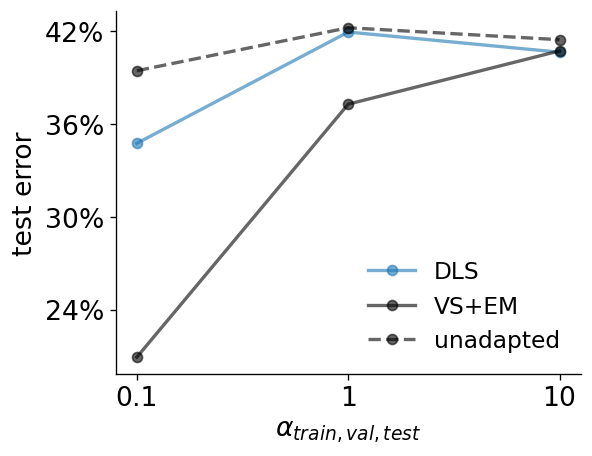

In [87]:
minimal_mode = True
# minimal_mode = False
prefix = ''
# prefix = 'DLS'
# prefix = 'EM'
replace_arc_in_variant = True

# error_bands = 'std'
# error_bands = 'sem'
error_bands = 'none'
line_opacity = 0.6
err_opacity = 0.2
line_width = 2

# phase_to_plot = 'best train'
# phase_to_plot = 'best val'
phase_to_plot = 'test'
metric_to_plot = metric_to_optimize[0]
# metric_to_plot = 'epoch prior loss'
# metric_to_plot = 'calibration MAE'
# metric_to_plot = 'accuracy - micro'
# metric_to_plot = 'accuracy - macro'

metric_to_plot = (metric_to_plot, phase_to_plot, 'mean')

vals_to_keep = {} # vals to keep for each arg in args_to_fix elements[1:]
# vals_to_keep['variant'] = [val for val in y_vals if val not in 
#         ['mean2 b->24->12', 'mean2 a->8']]
# vals_to_keep['loss_prior_lambda'] = [val for val in y_vals if val <1e6]
# vals_to_keep['training.rand_transforms'] = [val for val in y_vals if val != '30 mean cls std, zero clip']
# vals_to_keep['experiment_alpha'] = ['0.1']
# vals_to_keep['data.dataset'] = ['synthetic 1D uniform train-CLIPPED sigma=1.5']
# vals_to_keep['data.dataset'] = ['synthetic 1D uniform sigma=1.5']
# vals_to_keep['training.mixup_alpha'] = [0, 100]
# vals_to_keep['model.recurrence'] = [0]
# vals_to_keep['model.variant'] = ['in-0.1-128MS2-E-0.5-outM2-S']

baselines = [
    'em:VS', 'unadapted',
#     'train-clipped, trained on training', 'train-clipped, trained on test x', 'train-clipped, trained on test probs',
#     'no clipping, trained on training', 'no clipping, trained on test x', 'no clipping, trained on test probs',
#     'rlls-soft:VS',
]

baseline_x_as_DLS = True
baseline_tests_as_DLS = True # calculating mean and error only for n_loaded_tests baseline results, for paired comparison with DLS tests; n_loaded_tests_ = n_loaded_tests * len(search_grid_dict['cfg.seed'])
# baseline_tests_as_DLS = False

# arg_for_line_style = 'model.variant'
# arg_for_line_style = 'data.input_source'
arg_for_line_style = ''

one_minus_metric = True # y = 1-y
yscale = 'linear'
format_y_as_percents = True

# one_minus_metric = False
# yscale = 'log'
# format_y_as_percents = False

# y_percents_precision = 1
y_percents_precision = 0
n_y_ticks = 4

show_legend=True
# show_legend=False
# show_legend_title = True
show_legend_title = False
# legend_box = True
legend_box = False
legend_loc = 'best'
legend_separator = ' | '
legend_bbox = None
# legend_loc = 'upper left'
# legend_bbox = (0, -0.2)
# legend_bbox = (-0.2, -0.2)


log10_xvals = True
# log10_xvals = False
xscale = 'linear'
# xscale = 'symlog'
symlog_linthresh = 0.1
x_precision = -1
scientific_xaxis = False
# scientific_xaxis = True
xticks_by_x = True
# xticks_by_x = False
sort_x = True

title_font_size=14

manual_legend_labels = None
# manual_legend_labels = [
#             'DLS: reordered by EM+VS y_pred' ,
#             'DLS: not reordered',
#             'DLS: reordered by y_pred',
#             'DLS: reordered by y_true',
#             'EM+VS', 'unadapted']

# ------------------------------------------------

fig, plotted_df = plot()
# plt.xlim([0,3])
# plt.ylim([0.34,0.41])

In [82]:
print("Analysis:", os.path.split(analysis_path)[-1])
print("Search grid:")
pprint(search_grid_dict)

Analysis: l3vsgmd2 - 2080 cifar100 res3 PEN LayerParsed exp_alpha on all Adam plateau
Search grid:
{'experiment_alpha': {'1', '10', '0.1'},
 'model.variant': {'in-0.1-256MS2-E-128MS2-E-0.5-outMS2',
                   'in-0.3-128M2-E-0.75-outM2',
                   'in-128MS2-E-0.5-outMS2'},
 'training.batch_size': {2000, 1000, 128, 256},
 'training.lr': {1e-05, 0.0001, 0.001}}


# Downloading & analyzing result files

## Finding optimal runs

In [ ]:
# # vals_to_keep_ = {}
# vals_to_keep_ = {'data.test.Dirichlet_alpha': 0.1}
# # vals_to_keep_ = {'experiment_alpha': 0.1}
# # ----------------------
# opt_df_ = opt_df.copy()
# for arg,val in vals_to_keep_.items():
#     opt_df_ = opt_df_[opt_df_[('','',arg)]==val]
# display(opt_df_)
# assert len(opt_df_)==1, f"len(opt_df_) = {len(opt_df_)} -> change args_to_fix or vals_to_keep_ to have a single row for opt args!"

# opt_args = {}
# for arg in args_to_opt:
#     arg_ = 'OPT ' + arg.split('.')[-1].strip()
#     opt_args[arg] = (opt_df_[('','',arg_)].iloc[0])
# print("opt_args:", opt_args)

# opt_runs = runs_args_df.T.copy()
# for arg,val in vals_to_keep_.items():
#     if arg=='variant':
#         arg = 'model.variant'
#     opt_runs = opt_runs[opt_runs[arg]==val]
# for arg,val in opt_args.items():
#     opt_runs = opt_runs[opt_runs[arg]==val]
# display(opt_runs)
# opt_run_ids = list(opt_runs.index)
# print("opt_runs:", opt_run_ids)

In [ ]:
# # val_to_keep_ = {}
# val_to_keep_ = {'data.test.Dirichlet_alpha': 0.1}
# # ----------------------
# agg_df_ = agg_df.copy()
# for arg,val in val_to_keep_.items():
#     agg_df_ = agg_df[agg_df[('', '', arg)] == val]
    

## Downloading results for selected runs 

In [ ]:
# selected_runs = opt_run_ids
selected_runs = ['1f2woqmw']
# ------------------------------
results_dict = {}
for run_id in tqdm(selected_runs):
    run = api.run('%s/%s/%s'%(user, project, run_id))
    file = run.file("results.torch").download(root='wandb/temp', replace=(True))
    results = torch.load(file.name)
    results_dict[run_id] = results
    file.close()
    os.remove(file.name)

## `UNCOMPLETED` Plotting training curves

Instead, use section 4.2

In [ ]:
# metric = 'accuracy - micro'
# # -----------------------------

# training_stats = {f'{metric} <train>':[], f'{metric} <val>':[]}
# for run_id in selected_runs:
#     results = results_dict[run_id]
#     for phase in ['train', 'val']:
#         metric_dict = {}
#         for epoch in results[phase]:
#             metric_dict[epoch] = results[phase][epoch][metric]
#         metric_df = pd.DataFrame(metric_dict)
#         raise
# # label_dists = pd.concat(tests_stats['label dist'], axis=1)
# # accuracies = pd.concat(tests_stats['accuracy'], axis=1)

## Per-class analysis

In [ ]:
# tests_stats = {'label dist':[], 'accuracy':[]}
# for run_id in selected_runs:
#     results = results_dict[run_id]
#     for key in results:
#         if 'test ' in key:
#             cls_stats_df = pd.DataFrame(results[key]['class'])
#             cls_stats_df['label dist'] = cls_stats_df['positives']/cls_stats_df['positives'].sum()
#             cls_stats_df.sort_values(by='positives', ascending=False, inplace=True)
#             cls_stats_df.index = range(len(cls_stats_df))
#             cls_stats_df.rename(columns={
#                 col:f'{col} <{key}> <{run_id}>' for col in ['label dist', 'accuracy']}, inplace=True)
#             for col in ['label dist', 'accuracy']:
#                 tests_stats[col].append(cls_stats_df[f'{col} <{key}> <{run_id}>'])
# label_dists = pd.concat(tests_stats['label dist'], axis=1)
# accuracies = pd.concat(tests_stats['accuracy'], axis=1)

In [ ]:
phase = 'test'
# phase = 'train'
# phase = 'val'
epoch = -1 # if phase != 'test'
# ----------------------------------------------------
if phase!='test':
    assert len(selected_runs) == 1
    epoch = sorted(results_dict[run_id][phase].keys())[epoch]

stats = {'label dist':[], 'accuracy':[]}
if phase == 'test':
    for run_id in selected_runs:
        results = results_dict[run_id]
        for key in results:
            if 'test ' in key:
                cls_stats_df = pd.DataFrame(results[key]['class'])
                cls_stats_df['label dist'] = cls_stats_df['positives']/cls_stats_df['positives'].sum()
                cls_stats_df.sort_values(by='positives', ascending=False, inplace=True)
                cls_stats_df.index = range(len(cls_stats_df))
                cls_stats_df.rename(columns={
                    col:f'{col} <{key}> <{run_id}>' for col in ['label dist', 'accuracy']}, inplace=True)
                for col in ['label dist', 'accuracy']:
                    stats[col].append(cls_stats_df[f'{col} <{key}> <{run_id}>'])
    label_dists = pd.concat(stats['label dist'], axis=1)
    accuracies = pd.concat(stats['accuracy'], axis=1)
else:
    for run_id in selected_runs:
        results = results_dict[run_id][phase][epoch]
        cls_stats_df = pd.DataFrame(results['class'])
        cls_stats_df['label dist'] = cls_stats_df['positives']/cls_stats_df['positives'].sum()
        cls_stats_df.sort_values(by='positives', ascending=False, inplace=True)
        cls_stats_df.index = range(len(cls_stats_df))
        cls_stats_df.rename(columns={
            col:f'{col} <{phase}> <{run_id}>' for col in ['label dist', 'accuracy']}, inplace=True)
        for col in ['label dist', 'accuracy']:
            stats[col].append(cls_stats_df[f'{col} <{phase}> <{run_id}>'])
    label_dists = pd.concat(stats['label dist'], axis=1)
    accuracies = pd.concat(stats['accuracy'], axis=1)

In [ ]:
figsize = (4,4)
# figsize = None
# style = '-o'
style = '-'
line_opacity = 0.8
err_opacity = 0.4
line_width = 1.5
# ------------------------------

fig, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(axis='y', colors='r')
ax1.set_ylabel('class error', color='r')
label_dists_mean = label_dists.mean(axis=1)
df = accuracies
means = (1-df).mean(axis=1)
x = means.index
y = means
err = (1-df).std(axis=1)

base_line = ax1.plot(x, y, style, label='class error', color='r',
                     alpha=line_opacity, linewidth=line_width)
ax1.fill_between(x, y + err, y - err, facecolor=base_line[0].get_color(), alpha=err_opacity)

x = label_dists_mean.index
y = label_dists_mean
err = label_dists.std(axis=1)
ax2 = ax1.twinx()
ax2.set_ylabel('label distribution', color='b')
ax2.tick_params(axis='y', colors='b')
base_line = ax2.plot(x, y, style, label='label distribution', color='b',
                     alpha=line_opacity, linewidth=line_width)
ax2.fill_between(x, y + err, y - err, facecolor=base_line[0].get_color(), alpha=err_opacity)
# plt.yscale('log')
# fig.legend()
from matplotlib.ticker import FuncFormatter
format = '{:.%s%%}'%(0)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format.format(y)))
# ax1.locator_params(nbins=4)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format.format(y)))
ax1.locator_params(axis='y', nbins=4)
ax2.locator_params(axis='y', nbins=4)
# plt.locator_params(axis='x', nbins=3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.set_xlabel("class index (descending probability)")
# if 'vals_to_keep_' in globals() and opt_args in globals():
#     print(f"class stats for {vals_to_keep_} {opt_args}")
if phase == 'test':
    plt.title("test class distributions")
else:
    plt.title(f"{phase} class distributions on epoch {epoch}")
fig.patch.set_facecolor('white')
plt.show()

# Analyzing a single run

## Downloading/selecting run

In [ ]:
run

In [ ]:
# run_path = 'ozziko/DLS_6/14u6z3n4'
# run = api.run(run_path)
# --------------------------------------------------------------
if run.state != 'finished':
    raise RuntimeError("run is unfinished!")
run_history_df = run.history()
run_history_df

In [ ]:
# best_run_row = runs_selected_metrics_df['accuracy - micro <test>'].argmax()

# metric = 'accuracy - micro <best val>'
# metric = 'accuracy - micro <test>'
# i_top = 0
# run_idx = runs_selected_metrics_df[metric].sort_values(ascending=False).index[i_top]

# run_idx = '3uabw9aj'
# ----------------------------------------------------------------

# run_idx

# run_is_selected = False
# for run in runs:
#     if run.id==run_idx:
#         run_is_selected = True

# if run_is_selected:
#     run_history_df = run.history()
#     display(run_history_df)
# else:
#     print("run_idx not found")

## Plotting training curves

In [ ]:
run_selected_metrics = """accuracy - micro <train>, accuracy - micro <val>"""
# run_selected_metrics = """accuracy - macro <train>, accuracy - macro <val>"""
# run_selected_metrics = """accuracy - micro <train>, accuracy - micro <val>,
# accuracy - macro <train>, accuracy - macro <val>"""
# run_selected_metrics = """ loss per sample <train>, loss per sample <val>"""
# run_selected_metrics = """label loss per sample <train>, label loss per sample <val>,
# lambda * prior loss per sample <train>, lambda * prior loss per sample <val>
# """
# run_selected_metrics = """loss per sample <train>, loss per sample <val>"""
format_y_as_percents = True
# format_y_as_percents = False
# log_y = True
log_y = False
y_lim = []
# y_lim = [0.9,1]
# y_lim = [0,0.5]
opacity = 0.7
fig_size = (4,4)
# fig_size = None
# style = '-x'
style = '-'
linewidth = 2
# ---------------------------

run_selected_metrics = [splt.strip() for splt in run_selected_metrics.replace('\n','').split(',')]
selected_run_history_df = pd.DataFrame()
for metric in run_selected_metrics:
    metric_history_series = run_history_df[metric].dropna()
    metric_history_series.index = range(len(metric_history_series))
    selected_run_history_df[metric] = metric_history_series
selected_run_history_df.index.name = 'epoch'

parsed_run_selected_metrics = []
for metric in run_selected_metrics:
    metric_ = metric[:metric.find(' <')]
    phase = metric[metric.find('<')+1:metric.find('>')]
    parsed_run_selected_metrics.append((metric_, phase))

if len(set([metric for metric,phase in parsed_run_selected_metrics]))==1:
    same_metric_different_phases = True
else:
    same_metric_different_phases = False

fig = plt.figure(figsize=fig_size)
for i, (metric,phase) in enumerate(parsed_run_selected_metrics):
    if same_metric_different_phases:
        label = phase
    else:
        label = run_selected_metrics[i]
        
    plt.plot(selected_run_history_df.iloc[:,i], style, label=label, alpha=opacity, linewidth=linewidth)


if same_metric_different_phases:
    plt.ylabel(metric)
    legend_title = 'phase'
else:
    legend_title = ''

plt.legend(loc='best',
#            title='phase',
           fontsize=12, title_fontsize=12)
    
plt.xlabel('epoch')
if format_y_as_percents:
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
if log_y:
    plt.yscale('log')
if len(y_lim)>0:
    plt.ylim(y_lim)
fig.patch.set_facecolor('white')
plt.show()
display(selected_run_history_df)

# Misc

In [ ]:
df = pd.read_excel('analysis/synthetic data comparison.xlsx')
df['clip'] = df['dataset'].apply(lambda x:'clip' if 'CLIPPED' in x else 'no clipping')
df

In [ ]:
df.groupby(['architecture', 'inputs'])

In [ ]:
# fig = plt.figure()
# sns.lineplot(df, x='test alpha', y='test mean micro accuracy', hue='architecture', style='inputs')
sns.lineplot(df, x='test alpha', y='n_tests')

In [ ]:
df = pd.read_excel('analysis/resnet3 vs wide resnet.xlsx', index_col='test alpha')
df

In [ ]:
fig = plt.figure()
df.plot(ax=plt.gca(), style='-o')
plt.xscale('log')
plt.ylabel('test error')
fig.patch.set_facecolor('white')

In [ ]:
# agg_std = df.groupby(non_reduced_args, as_index=True).std()
# agg_median = df.groupby(non_reduced_args, as_index=True).median()

# pivot_df = df.pivot_table(
#     index=non_reduced_args, values=selected_metrics, aggfunc=['median', 'mean', 'std'])
# if not as_index:
#     pivot_df = pivot_df.reset_index()
#
# # re-indexing column levels by metric -> agg, instead of agg -> metric
# pivot_df = pivot_df.reorder_levels(axis=1, order=[1,0])
# pivot_df = pivot_df.reindex(selected_metrics, axis=1, level=0)

# runs_swept_args_and_selected_metrics_pivot_df = pivot_df
# runs_swept_args_and_selected_metrics_pivot_df.to_excel(pjoin(analysis_path, 'runs_swept_args_and_selected_metrics_pivot_df.xlsx'))

# # max on cfg.seed
# agg_df = df.groupby(list(set(swept_args) - {'cfg.seed'}), as_index=as_index).max()
# del agg_df['cfg.seed']
#
# agg_df1 = agg_df.groupby(non_swept_args, as_index=as_index).mean()
# agg_df1['agg'] = 'max(cfg.seed) -> mean(data.seed)'
# del agg_df1['data.seed']
#
# # mean and std on data.seed
# agg_df2 = agg_df.groupby(non_swept_args, as_index=as_index).std()
# agg_df2['agg'] = 'max(cfg.seed) -> std(data.seed)'
# del agg_df2['data.seed']
#
#
# cols = non_swept_args + ['agg'] + selected_metrics
# agg_runs_swept_args_and_selected_metrics_df = pd.concat([agg_df1, agg_df2], axis=0)
# agg_runs_swept_args_and_selected_metrics_df.sort_values(by=non_swept_args, inplace=True)
# agg_runs_swept_args_and_selected_metrics_df = agg_runs_swept_args_and_selected_metrics_df[cols]
# agg_runs_swept_args_and_selected_metrics_df.to_excel(pjoin(analysis_path, 'agg_runs_swept_args_and_selected_metrics_df.xlsx'))



# #%% early stopping epoch histogram
# plt.figure(dpi=150)
# early_stop_epoch = runs_selected_metrics_df['best epoch']
# early_stop_epoch.hist(ax=plt.gca())
# plt.title("early stopping epoch histogram\nmean: %1.1f, std: %1.1f"%(early_stop_epoch.mean(), early_stop_epoch.std()))
# plt.ylabel('counts')
# plt.xlabel("early stopping epoch")
# plt.grid('on')
# plt.show()
#
# #%%
# (1.3**2 + 1.6**2)**0.5
#
#
# #%% comparing sweep args
# analysis_name1 = "simple baseline"
# analysis_name2 = "simple DLS"
# # -----------------------------------------------------------------------------------------
# import pandas as pd
# from os.path import join as pjoin
#
# analysis_path1 = pjoin('analysis', analysis_name1, 'runs_args_df_ext.xlsx')
# analysis_path2 = pjoin('analysis', analysis_name2, 'runs_args_df_ext.xlsx')
#
# runs_args_df_ext1 = pd.read_excel(analysis_path1)
# runs_args_df_ext1.set_index(['arg'], inplace=True)
# runs_args_df_ext2 = pd.read_excel(analysis_path2)
# runs_args_df_ext2.set_index(['arg'], inplace=True)
#
# non_swept_args1 = runs_args_df_ext1.query("~is_swept").iloc[:,0]
# non_swept_args2 = runs_args_df_ext2.query("~is_swept").iloc[:,0]
#
# non_swept_args_comparison_df = pd.concat([non_swept_args1,non_swept_args2], axis=1, join='outer')
# non_swept_args_comparison_df.columns = [analysis_name1,analysis_name2]
# non_swept_args_comparison_df.index.name = 'arg'
# # non_swept_args_comparison_df['n_unique'] = non_swept_args_comparison_df.astype(str).nunique(axis=1)
# non_swept_args_comparison_df['is_equal'] = non_swept_args_comparison_df[analysis_name1] == non_swept_args_comparison_df[analysis_name2]
# non_swept_args_comparison_df['is_equal'] = non_swept_args_comparison_df['is_equal'].astype(int)
# non_swept_args_comparison_df.to_excel(pjoin('analysis', f'args - {analysis_name1} -VS- {analysis_name2}.xlsx'))
#
#
# #%% reducing by optimal_run_id
# reduced_args = 'cfg.seed, data.seed'.split(', ')
# reducing_args = list(optimal_sept_args[~optimal_sept_args.index.isin(reduced_args)].index)
# optimal_runs_df = runs_summary_and_metrics_df.copy()
# for arg in reducing_args:
#     optimal_runs_df = optimal_runs_df[optimal_runs_df[arg]==optimal_sept_args[arg]]
# optimal_runs_df
#
#
# #%%
# metric = 'accuracy - micro <test>'
#
# logger.info(f"{metric} mean, std, median: %.3f, %.4f, %.3f"%(
#     optimal_runs_df[metric].mean(), optimal_runs_df[metric].std(), optimal_runs_df[metric].median()
# ))